# Consumer Complaints Text Classification

This notebook performs multi-class text classification on the **Consumer Complaint Dataset**.

Categories considered:
- 0: Credit reporting, repair, or other
- 1: Debt collection
- 2: Consumer Loan
- 3: Mortgage

Models used:
- Logistic Regression
- Linear SVM (LinearSVC)
- Multinomial Naive Bayes


In [1]:
# Install required packages if needed
!pip install pandas scikit-learn matplotlib seaborn nltk joblib imbalanced-learn tqdm --quiet
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

You should consider upgrading via the 'C:\Users\ADITYA\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADITYA\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADITYA\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\ADITYA\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [2]:
import os, re, string, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Paths (adjust base_dir to your split CSVs)
base_dir = "./splits"  # folder where your 23 parts are
part_pattern = "Consumer_Complaints_part"
filtered_output = "complaints_filtered_all.csv"
use_filtered_cache = True
max_per_class = 30000  # sample size per class to fit in memory
random_state = 42

keep_categories = [
    "Credit reporting, credit repair services, or other personal consumer reports",
    "Debt collection",
    "Consumer Loan",
    "Mortgage"
]

category_map = {
    "Credit reporting, credit repair services, or other personal consumer reports": 0,
    "Debt collection": 1,
    "Consumer Loan": 2,
    "Mortgage": 3
}

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

## Step 1 — Create consolidated filtered CSV from parts

In [3]:
parts = sorted(glob.glob(os.path.join(base_dir, f"{part_pattern}*.csv")))
print(f"Found {len(parts)} part files.")

if not use_filtered_cache or not os.path.exists(filtered_output):
    written = False
    for i, p in enumerate(parts, start=1):
        print(f"Processing {i}/{len(parts)}: {p}")
        for chunk in pd.read_csv(p, chunksize=200_000, iterator=True, encoding='utf-8', low_memory=True):
            cols = [c for c in ['Consumer complaint narrative', 'Product'] if c in chunk.columns]
            chunk = chunk[cols]
            sub = chunk[chunk['Product'].isin(keep_categories)]
            if sub.shape[0] > 0:
                mode = 'w' if not written else 'a'
                header = not written
                sub.to_csv(filtered_output, index=False, mode=mode, header=header)
                written = True
    print("Filtered consolidated file created:", filtered_output)
else:
    print("Using cached filtered file:", filtered_output)

Found 23 part files.
Using cached filtered file: complaints_filtered_all.csv


## Step 2 — Load filtered CSV and EDA

Rows after filter: 1314725
Product
Credit reporting, credit repair services, or other personal consumer reports    807277
Debt collection                                                                 364007
Mortgage                                                                        133980
Consumer Loan                                                                     9461
Name: count, dtype: int64


C:\Users\ADITYA\AppData\Local\Temp\ipykernel_7868\2513480616.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sampled = df.groupby('Product', group_keys=False).apply(


After sampling: Product
Credit reporting, credit repair services, or other personal consumer reports    30000
Debt collection                                                                 30000
Mortgage                                                                        30000
Consumer Loan                                                                    9461
Name: count, dtype: int64


100%|███████████████████████████████████████████████████████████████████████████| 99461/99461 [01:49<00:00, 909.49it/s]


           text_len
count  99461.000000
mean     106.159480
std      133.498849
min        1.000000
25%       35.000000
50%       69.000000
75%      129.000000
max     3480.000000


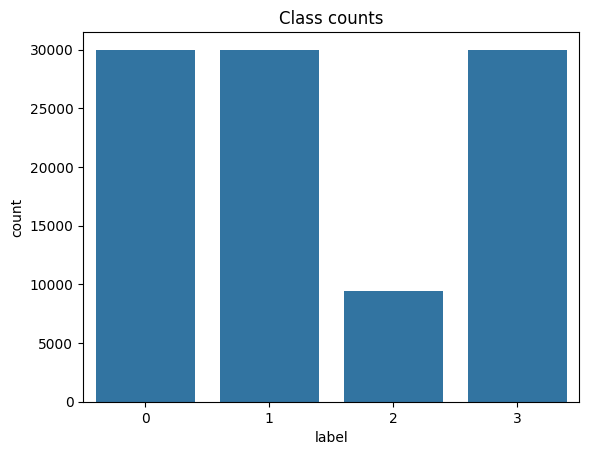

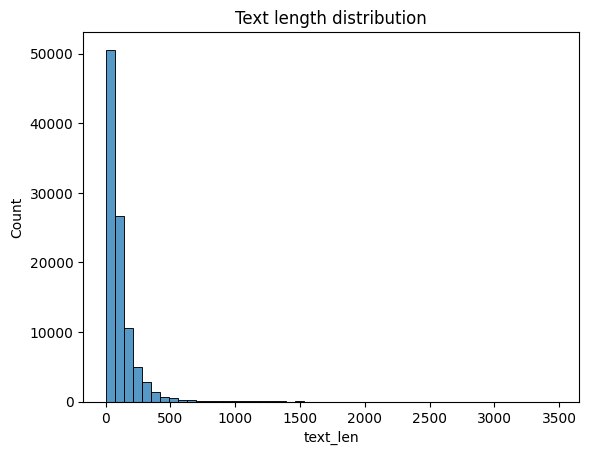

In [4]:
df = pd.read_csv(filtered_output, usecols=['Consumer complaint narrative', 'Product'])
df = df.dropna(subset=['Consumer complaint narrative']).reset_index(drop=True)
print("Rows after filter:", len(df))
print(df['Product'].value_counts())

# Sample per class
df_sampled = df.groupby('Product', group_keys=False).apply(
    lambda g: g.sample(n=min(len(g), max_per_class), random_state=random_state)
).reset_index(drop=True)
print("After sampling:", df_sampled['Product'].value_counts())

df_sampled['label'] = df_sampled['Product'].map(category_map)
df_sampled['clean_text'] = df_sampled['Consumer complaint narrative'].progress_apply(clean_text)

# Quick EDA
df_sampled['text_len'] = df_sampled['clean_text'].apply(lambda s: len(s.split()))
print(df_sampled[['text_len']].describe())

sns.countplot(x='label', data=df_sampled)
plt.title("Class counts")
plt.show()

sns.histplot(df_sampled['text_len'], bins=50)
plt.title("Text length distribution")
plt.show()

## Step 3 — Train/Test Split + TF-IDF

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df_sampled['clean_text'].values
y = df_sampled['label'].values
X_train_text, X_test_text, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                              stratify=y, random_state=random_state)

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2), min_df=5)
X_train = tfidf.fit_transform(X_train_text)
X_test = tfidf.transform(X_test_text)
print("TF-IDF shapes:", X_train.shape, X_test.shape)

TF-IDF shapes: (79568, 20000) (19893, 20000)


## Step 4 — Train Models (LogReg, LinearSVC, NB, RF)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
import joblib

models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, solver='saga', n_jobs=-1, random_state=random_state),
    "LinearSVC": LinearSVC(max_iter=5000, random_state=random_state),
    "MultinomialNB": MultinomialNB(),
}

results = {}
for name, clf in models.items():
    print("Training", name)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    results[name] = {'model': clf, 'accuracy': acc, 'f1': f1}
    print(f"{name}: acc={acc:.4f}, f1_macro={f1:.4f}")
    print(classification_report(y_test, y_pred, digits=4))
    print("-"*50)

Training LogisticRegression
LogisticRegression: acc=0.8924, f1_macro=0.8768
              precision    recall  f1-score   support

           0     0.8651    0.8870    0.8759      6000
           1     0.8720    0.8652    0.8686      6000
           2     0.8481    0.7639    0.8038      1893
           3     0.9525    0.9657    0.9590      6000

    accuracy                         0.8924     19893
   macro avg     0.8844    0.8704    0.8768     19893
weighted avg     0.8919    0.8924    0.8919     19893

--------------------------------------------------
Training LinearSVC
LinearSVC: acc=0.8900, f1_macro=0.8745
              precision    recall  f1-score   support

           0     0.8688    0.8820    0.8754      6000
           1     0.8664    0.8605    0.8635      6000
           2     0.8294    0.7755    0.8015      1893
           3     0.9521    0.9637    0.9578      6000

    accuracy                         0.8900     19893
   macro avg     0.8792    0.8704    0.8745     19893


## Step 5 — Model Comparison and Save Best

                    accuracy        f1
model                                 
LogisticRegression  0.892424  0.876822
LinearSVC           0.890012  0.874545
MultinomialNB       0.853164  0.831028


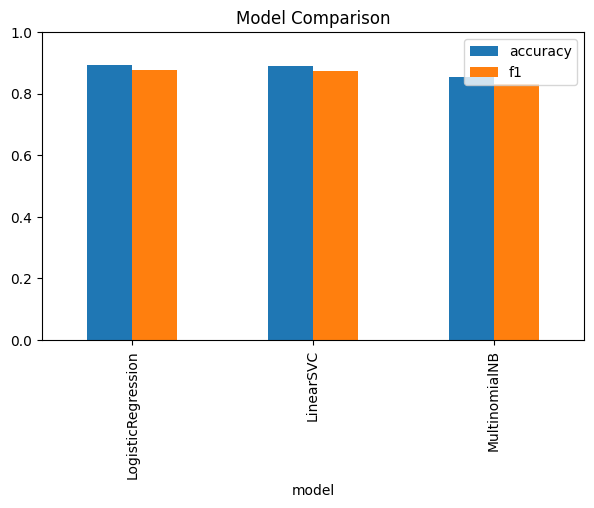

Best model: LogisticRegression


['best_model_LogisticRegression.joblib']

In [10]:
res_df = pd.DataFrame([
    {'model': k, 'accuracy': v['accuracy'], 'f1': v['f1']}
    for k,v in results.items()
]).set_index('model').sort_values('f1', ascending=False)
print(res_df)

res_df.plot(kind='bar', figsize=(7,4), ylim=(0,1))
plt.title("Model Comparison")
plt.show()

best_name = res_df.index[0]
best_model = results[best_name]['model']
print("Best model:", best_name)

joblib.dump(tfidf, "tfidf_vectorizer.joblib")
joblib.dump(best_model, f"best_model_{best_name}.joblib")

## Step 6 — Predictions

In [11]:
inv_map = {v:k for k,v in category_map.items()}

def predict_texts(texts):
    clean = [clean_text(t) for t in texts]
    Xv = tfidf.transform(clean)
    preds = best_model.predict(Xv)
    return [inv_map[int(p)] for p in preds]

samples = [
    "I found errors on my credit report and it lowered my score.",
    "I get calls from a debt collector about a loan I never took.",
    "My consumer loan application was denied despite good credit.",
    "My mortgage servicer charged me an incorrect fee."
]
print(predict_texts(samples))

['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Mortgage']
